In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import numpy as np
import scipy.stats as st
from scipy.stats.stats import pearsonr
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BicScore, K2Score, BDeuScore
from pgmpy.estimators import HillClimbSearch, PC, MmhcEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import warnings

<ipython-input-1-c3e4ebe4466f>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
warnings.filterwarnings(action='ignore')

In [2]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pd.options.display.float_format ='{:,.3f}'.format

In [5]:
data = pd.read_csv('energy_dataset.csv', delimiter=',', encoding='utf-8')

# Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [21]:
columns = ['generation biomass', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro run-of-river and poundage', 'generation wind onshore', 'price actual', 'price day ahead', 'total load actual', 'generation fossil gas']
target_columns = ['price actual', 'price day ahead', 'generation fossil gas']

data_subsample = data[columns]
data_subsample = data_subsample[1500:1600]
data_subsample.head()

,generation biomass,generation fossil hard coal,generation fossil oil,generation hydro run-of-river and poundage,generation wind onshore,price actual,price day ahead,total load actual,generation fossil gas
1500,399.000,"1,754.000",257.000,"1,366.000","2,678.000",47.920,39.000,"22,932.000","3,964.000"
1501,403.000,"1,639.000",256.000,"1,377.000","2,880.000",51.030,39.250,"22,969.000","3,708.000"
1502,397.000,"1,573.000",254.000,"1,349.000","3,043.000",43.890,40.120,"22,744.000","4,031.000"
1503,398.000,"1,602.000",254.000,"1,343.000","3,574.000",41.310,36.430,"21,706.000","3,796.000"
1504,395.000,"1,477.000",253.000,"1,335.000","4,302.000",41.790,35.680,"21,270.000","3,741.000"


In [23]:
df = data_subsample.dropna()

In [9]:
len(df)

100

In [10]:
df.dtypes

generation biomass                            float64
generation fossil gas                         float64
generation fossil hard coal                   float64
generation fossil oil                         float64
generation hydro run-of-river and poundage    float64
generation wind onshore                       float64
price actual                                  float64
price day ahead                               float64
total load actual                             float64
dtype: object

# Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [11]:
df_random = df.sample(frac=0.5)

In [12]:
def inverse_transform_sampling(data, distr):
  params = distr.fit(data)
  data_rnd = np.random.uniform(size=len(data))
  gen = distr(*params)
  return gen.ppf(data_rnd)

In [13]:
ts_1 = inverse_transform_sampling(df['price actual'], st.gamma)
ts_2 = inverse_transform_sampling(df['price day ahead'], st.gamma)
ts_3 = inverse_transform_sampling(df['generation fossil gas'], st.gamma)
df_inv_ts = pd.DataFrame({'price actual': ts_1, 'price day ahead': ts_2, 'generation fossil gas': ts_3})

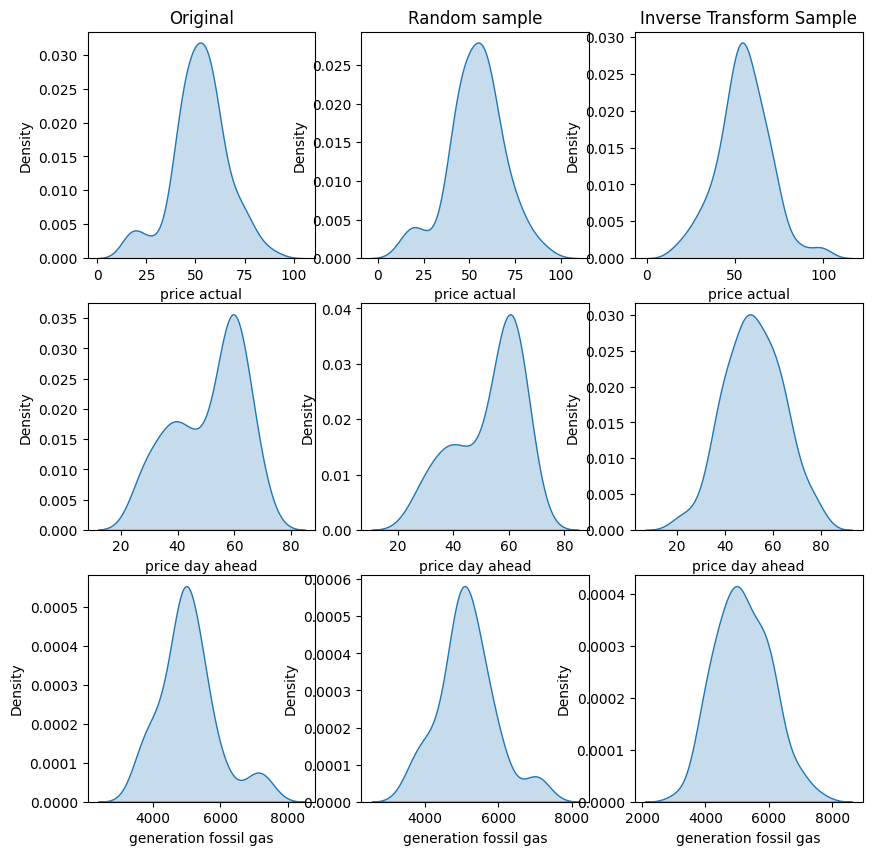

In [15]:
warnings.filterwarnings(action='ignore')
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax[0, 0].set_title('Original')
ax[0, 1].set_title('Random sample')
ax[0, 2].set_title('Inverse Transform Sample')
sns.kdeplot(df['price actual'], ax=ax[0, 0], shade=True)
sns.kdeplot(df_random['price actual'], ax=ax[0, 1], shade=True)
sns.kdeplot(df_inv_ts['price actual'], ax=ax[0, 2], shade=True)
sns.kdeplot(df['price day ahead'], ax=ax[1, 0], shade=True)
sns.kdeplot(df_random['price day ahead'], ax=ax[1, 1], shade=True)
sns.kdeplot(df_inv_ts['price day ahead'], ax=ax[1, 2], shade=True)
sns.kdeplot(df['generation fossil gas'], ax=ax[2, 0], shade=True)
sns.kdeplot(df_random['generation fossil gas'], ax=ax[2, 1], shade=True)
sns.kdeplot(df_inv_ts['generation fossil gas'], ax=ax[2, 2], shade=True)
plt.show()

In [18]:
print(df[target_columns].mean())
print(df_random[target_columns].mean())
print(df_inv_ts[target_columns].mean())

price actual               52.316
price day ahead            51.058
generation fossil gas   5,060.350
dtype: float64
price actual               53.663
price day ahead            52.757
generation fossil gas   5,148.160
dtype: float64
price actual               54.909
price day ahead            51.885
generation fossil gas   5,182.450
dtype: float64


In [19]:
print(df[target_columns].var())
print(df_random[target_columns].var())
print(df_inv_ts[target_columns].var())

price actual                190.053
price day ahead             154.775
generation fossil gas   735,086.997
dtype: float64
price actual                218.724
price day ahead             140.537
generation fossil gas   588,666.668
dtype: float64
price actual                217.883
price day ahead             142.850
generation fossil gas   742,336.414
dtype: float64


# Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

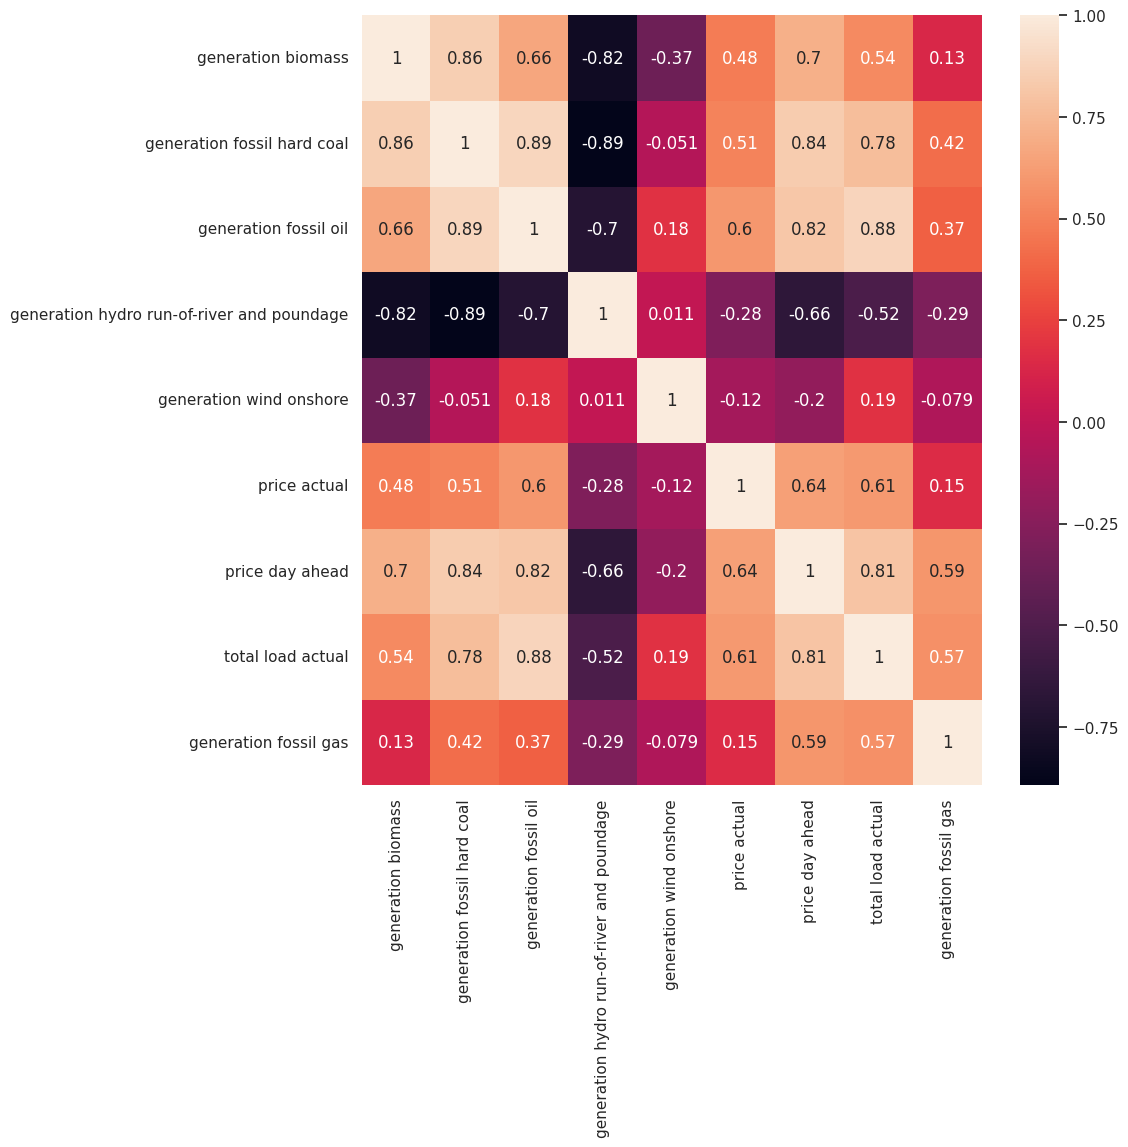

In [47]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

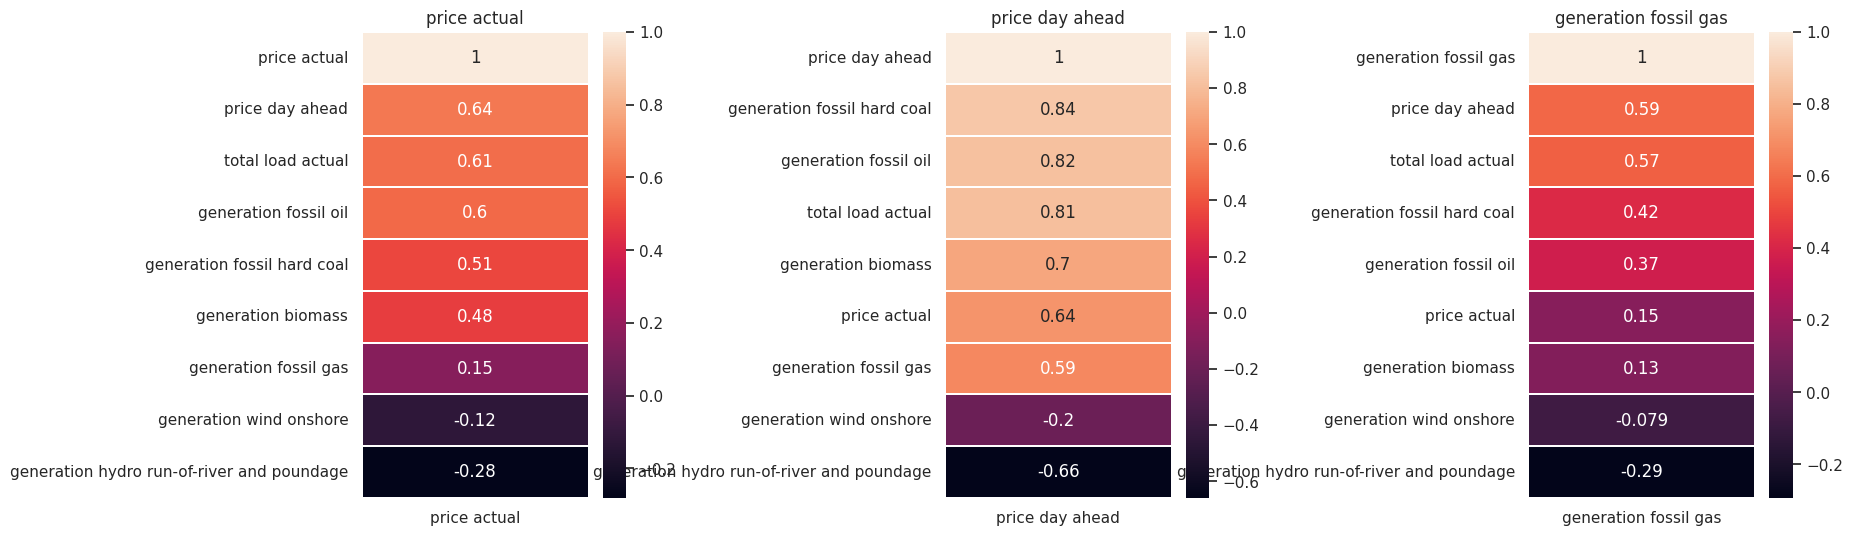

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.set_theme()
fig.tight_layout(pad=15.0)

ax[0].set_title('price actual')
ax[1].set_title('price day ahead')
ax[2].set_title('generation fossil gas')

sns.heatmap(
    df.corr()[['price actual']].sort_values(by='price actual', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[0]
)
sns.heatmap(
    df.corr()[['price day ahead']].sort_values(by='price day ahead', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[1]
)
sns.heatmap(
    df.corr()[['generation fossil gas']].sort_values(by='generation fossil gas', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[2]
)


plt.show()

# Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [18]:
columns

['generation biomass',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro run-of-river and poundage',
 'generation wind onshore',
 'price actual',
 'price day ahead',
 'total load actual']

In [27]:
pairs = [
    ('total load actual', 'generation fossil oil'),
    ('price actual', 'price day ahead'),
    ('total load actual', 'generation fossil gas'),
    ('generation fossil oil', 'price actual'),
    ('generation biomass', 'price actual')
]

model = BayesianModel(pairs)

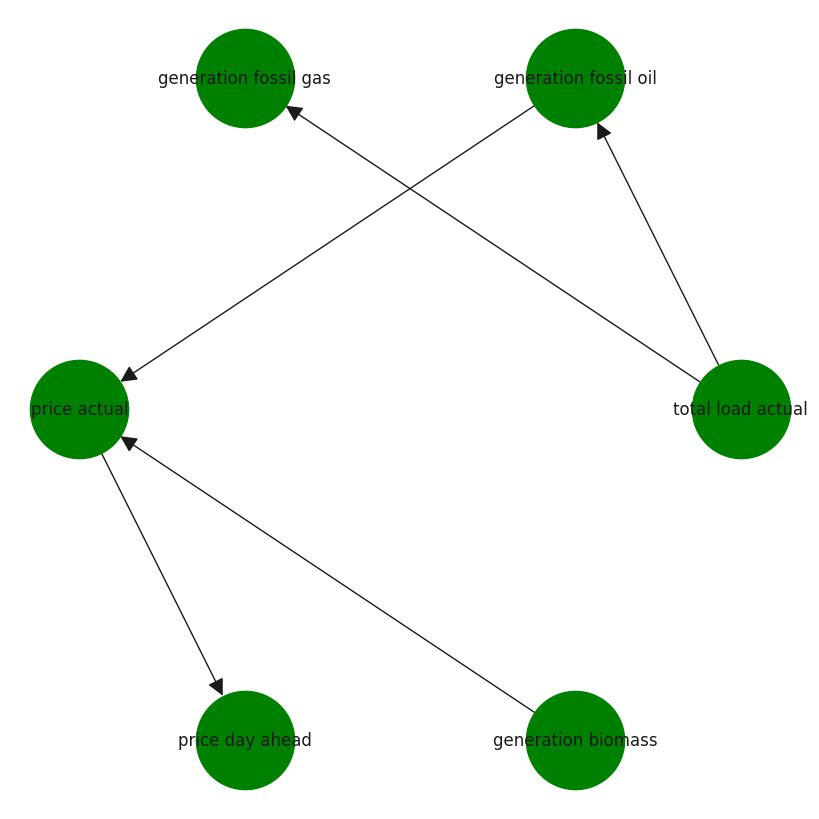

In [28]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.layout.circular_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [29]:
model.fit(df)

# Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [30]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BicScore, K2Score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import TreeSearch
from sklearn.preprocessing import KBinsDiscretizer

In [31]:
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
df_discrete = discretizer.fit_transform(df.values)
df_discrete = pd.DataFrame(df, columns=columns)

In [32]:
hc = HillClimbSearch(data=df_discrete)
model2 = hc.estimate(scoring_method=K2Score(df_discrete), show_progress=False)

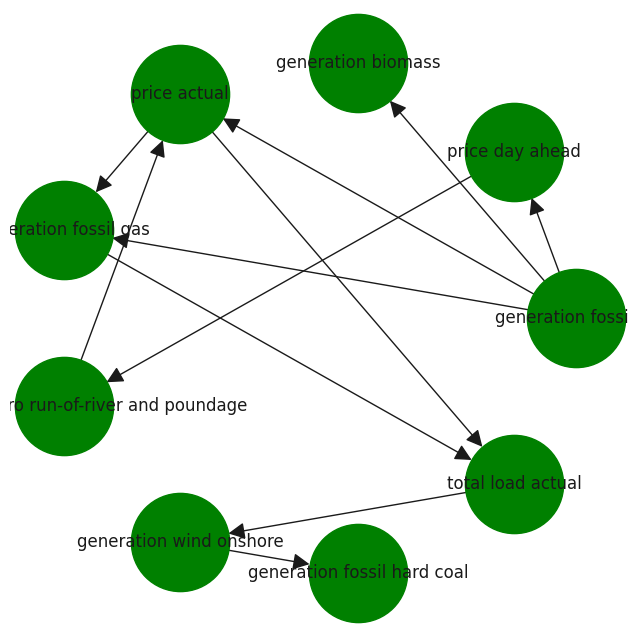

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
G = nx.DiGraph()
G.add_edges_from(model2.edges())
positions = nx.layout.circular_layout(G)
nx.draw(G, positions, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [34]:
ts = TreeSearch(df_discrete)
model3 = ts.estimate()

Building tree:   0%|          | 0/36.0 [00:00<?, ?it/s]

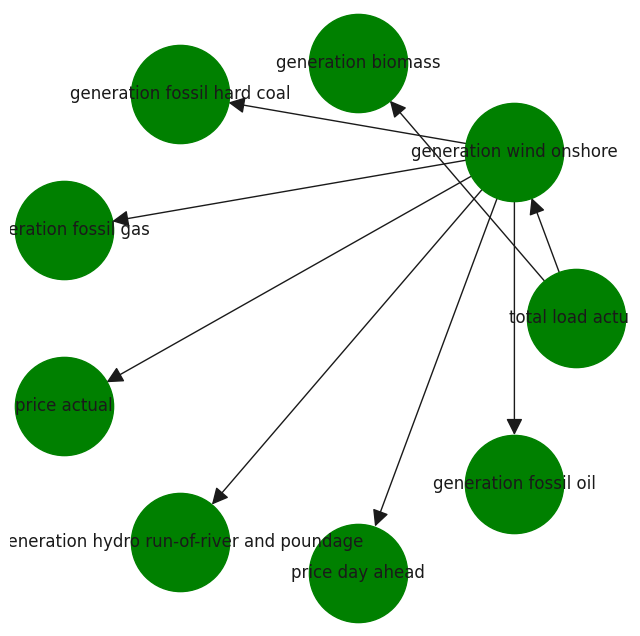

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
G = nx.DiGraph()
G.add_edges_from(model3.edges())
positions = nx.layout.circular_layout(G)
nx.draw(G, positions, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [36]:
print("Metrics:")
print("My bayesian network")
print(f'K2: {K2Score(df).score(model):.2f}')
print("PC")
print(f'K2: {K2Score(df_discrete).score(model2):.2f}')
print("Tree Search")
print(f'K2: {K2Score(df_discrete).score(model3):.2f}')

Metrics:
My bayesian network
K2: -2713.54
PC
K2: -4043.20
Tree Search
K2: -4062.90


# Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [37]:
def sampling (model, data, n):
    temp = BayesianModel(model.edges())
    temp.fit(data)
    sampler = BayesianModelSampling(temp)
    sample = sampler.forward_sample(size=n)
    return sample

In [38]:
mymodel_samples = sampling(model, df, df.shape[0])

  0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
hc_samples = sampling(model2, df_discrete, df_discrete.shape[0])

  0%|          | 0/9 [00:00<?, ?it/s]

In [40]:
ts_samples = sampling(model3, df_discrete, df_discrete.shape[0])

  0%|          | 0/9 [00:00<?, ?it/s]

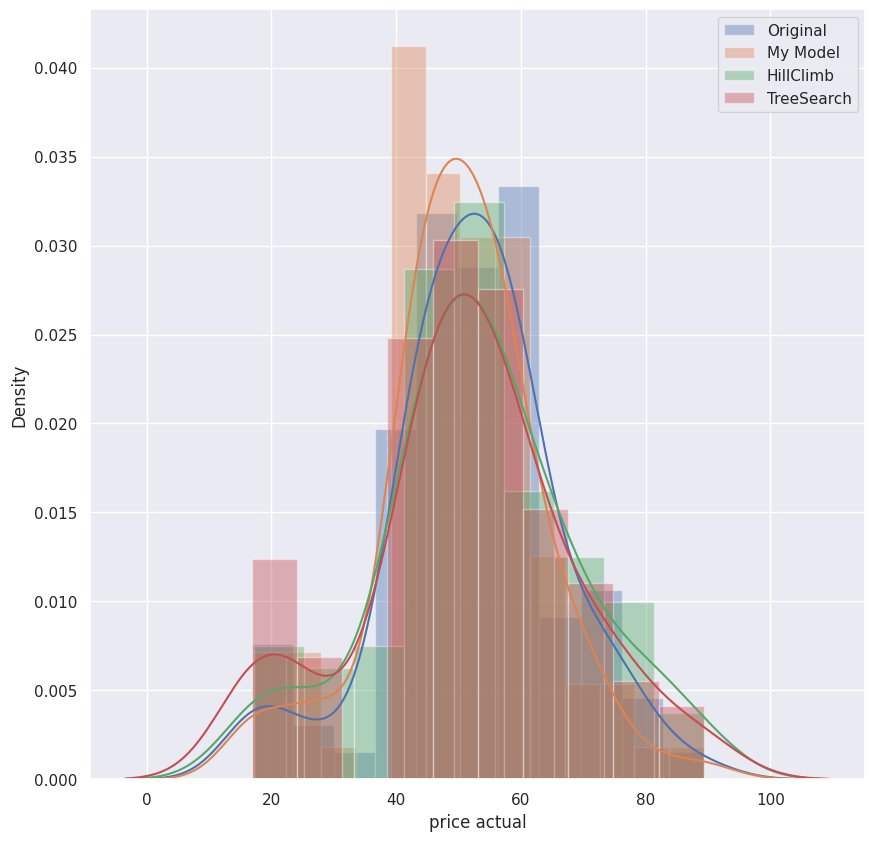

In [41]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(df['price actual'], label='Original')
sns.distplot(mymodel_samples['price actual'], label='My Model')
sns.distplot(hc_samples['price actual'], label='HillClimb')
sns.distplot(ts_samples['price actual'], label='TreeSearch')
plt.legend()
plt.show()

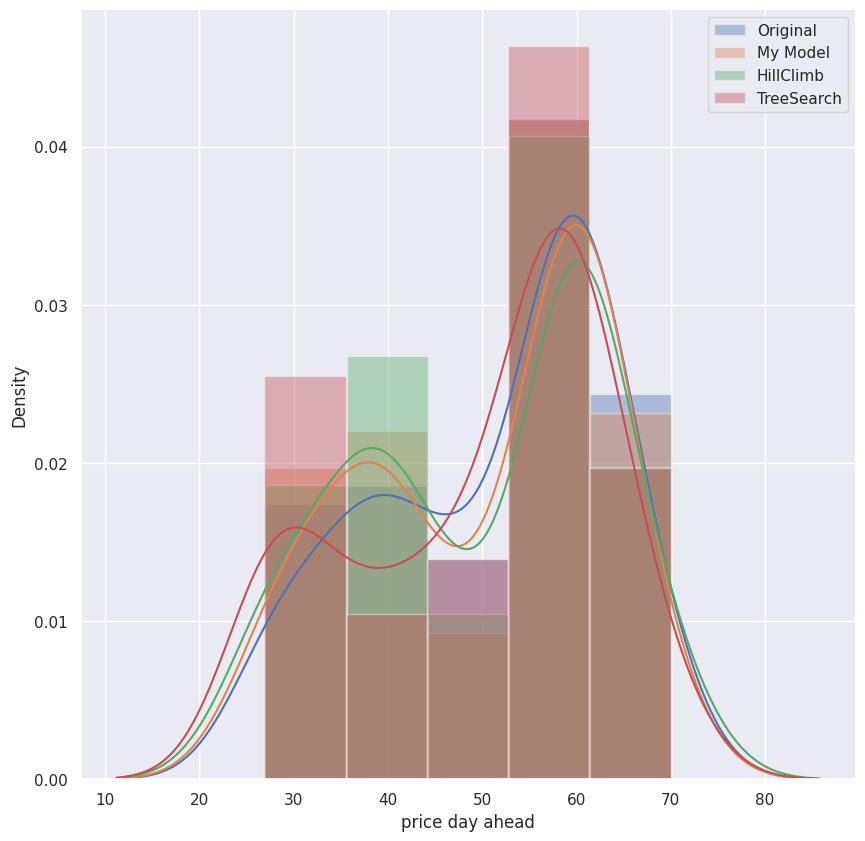

In [42]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(df['price day ahead'], label='Original')
sns.distplot(mymodel_samples['price day ahead'], label='My Model')
sns.distplot(hc_samples['price day ahead'], label='HillClimb')
sns.distplot(ts_samples['price day ahead'], label='TreeSearch')
plt.legend()
plt.show()

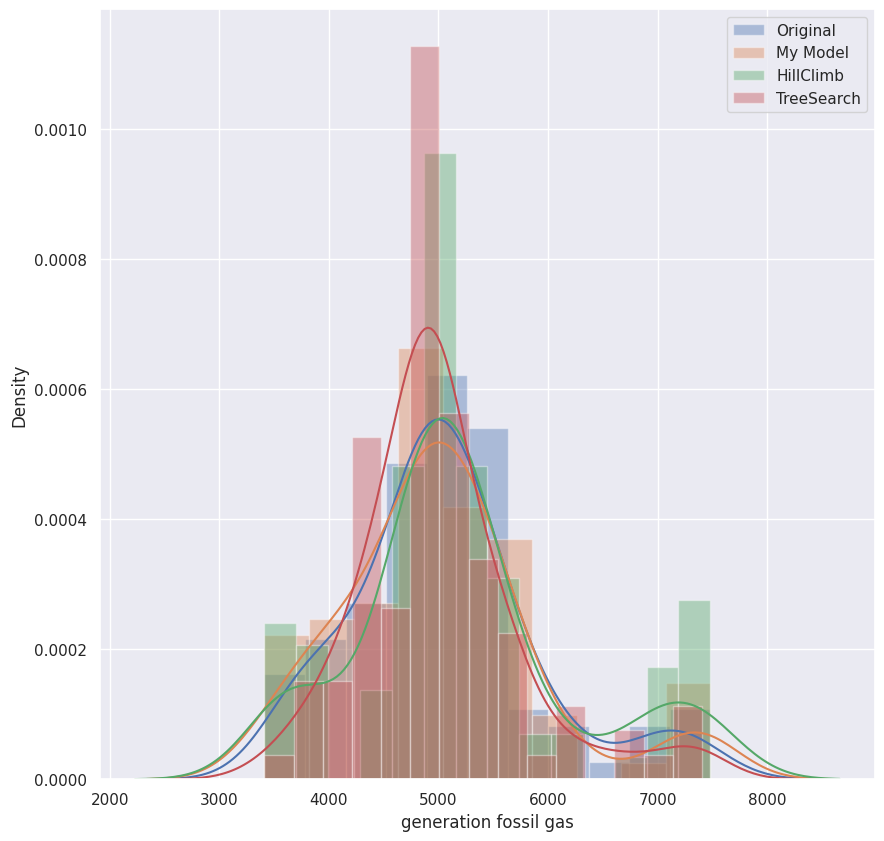

In [43]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(df['generation fossil gas'], label='Original')
sns.distplot(mymodel_samples['generation fossil gas'], label='My Model')
sns.distplot(hc_samples['generation fossil gas'], label='HillClimb')
sns.distplot(ts_samples['generation fossil gas'], label='TreeSearch')
plt.legend()
plt.show()

In [44]:
print("price actual. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(df['price actual'], mymodel_samples['price actual'])}")
print(f"Mean square error:{mean_squared_error(df['price actual'], mymodel_samples['price actual'])}")
print("price actual. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(df['price actual'], hc_samples['price actual'])}")
print(f"Mean square error:{mean_squared_error(df['price actual'], hc_samples['price actual'])}")
print("price actual. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(df['price actual'], ts_samples['price actual'])}")
print(f"Mean square error:{mean_squared_error(df['price actual'], ts_samples['price actual'])}")

price actual. Model: My Model
Mean absolute error:12.538599999999999
Mean square error:278.200478
price actual. Model: HillClimb
Mean absolute error:17.509700000000002
Mean square error:438.89699700000006
price actual. Model: TreeSearch
Mean absolute error:17.4864
Mean square error:521.005736


In [45]:
print("price day ahead. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(df['price day ahead'], mymodel_samples['price day ahead'])}")
print(f"Mean square error:{mean_squared_error(df['price day ahead'], mymodel_samples['price day ahead'])}")
print("price day ahead. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(df['price day ahead'], hc_samples['price day ahead'])}")
print(f"Mean square error:{mean_squared_error(df['price day ahead'], hc_samples['price day ahead'])}")
print("price day ahead. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(df['price day ahead'], ts_samples['price day ahead'])}")
print(f"Mean square error:{mean_squared_error(df['price day ahead'], ts_samples['price day ahead'])}")

price day ahead. Model: My Model
Mean absolute error:11.2859
Mean square error:224.34939100000003
price day ahead. Model: HillClimb
Mean absolute error:15.041300000000001
Mean square error:358.452659
price day ahead. Model: TreeSearch
Mean absolute error:14.900800000000002
Mean square error:335.865714


In [46]:
print("generation fossil gas. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(df['generation fossil gas'], mymodel_samples['generation fossil gas'])}")
print(f"Mean square error:{mean_squared_error(df['generation fossil gas'], mymodel_samples['generation fossil gas'])}")
print("generation fossil gas. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(df['generation fossil gas'], hc_samples['generation fossil gas'])}")
print(f"Mean square error:{mean_squared_error(df['generation fossil gas'], hc_samples['generation fossil gas'])}")
print("generation fossil gas. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(df['generation fossil gas'], ts_samples['generation fossil gas'])}")
print(f"Mean square error:{mean_squared_error(df['generation fossil gas'], ts_samples['generation fossil gas'])}")

generation fossil gas. Model: My Model
Mean absolute error:938.94
Mean square error:1531506.84
generation fossil gas. Model: HillClimb
Mean absolute error:1008.66
Mean square error:1744284.56
generation fossil gas. Model: TreeSearch
Mean absolute error:856.13
Mean square error:1297547.99
